In [1]:
CUDA_DEVICE = "1"

In [2]:
import numpy as np
from PIL import Image
import json
import os
import copy
import argparse
from tqdm import tqdm
import notebook_mesh_utils as nu

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_DEVICE

from tomo2mesh.projects.steel_am.coarse2fine import coarse_map, process_subset
from tomo2mesh.misc.voxel_processing import TimerGPU
from tomo2mesh.structures.voids import Voids
from tomo2mesh.porosity.params_3dunet import *
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.fbp.recon import recon_slice, recon_binned, recon_all

import cupy as cp
import tomo2mesh.fbp.subset as subset
import cupyx.scipy as cpsp
import tomo2mesh.misc.voxel_processing as vp
import skimage.filters as filters
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
metadata_fp = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/metadata/faber_mar21/faber_sam1_s12_crack_tomo/faber_sam1_s12_crack_tomo_TomoFastScan.dat'
override_path = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/tomo/faber_sam1_s12_crack_tomo'

scans = nu.extract_scan_data(metadata_fp, override_path)

In [4]:
nu.print_avail_scans(scans)

[0]: [173994, 175794]
[1]: [173994, 175794]
[2]: [173994, 175794]
[3]: [173994, 175794]
[4]: [173994, 175794]
[5]: [173994, 175794]
[6]: [173994, 175794]
[7]: [173994, 175794]
[8]: [173994, 175794]
[9]: [173994, 175794]
[10]: [173994, 175794]
[11]: [173994, 175794]
[12]: [173994, 175794]
[13]: [173994, 175794]
[14]: [173994, 175794]
[15]: [173994, 175794]
[16]: [173994, 175794]
[17]: [173994, 175794]
[18]: [173994, 175794]
[19]: [173994, 175794]
[20]: [173994, 175794]
[21]: [173994, 175794]
[22]: [173994, 175794]


In [5]:
selected_scan = 20 

scan = scans[selected_scan]
projs = nu.load_images(scan)

Loading Imgs: 100%|██████████| 1801/1801 [01:01<00:00, 29.44it/s]


In [6]:
center = projs.shape[-1]/2.0 # assuming that object is perfectly centered
print('Assuming object is perfectly centered...')

Assuming object is perfectly centered...


In [18]:
# Reconstruction Params
# ds = downsampling factor
pixel_ds = 1
scan_ds = 1
gpu_batch_size = 100

In [19]:
recon = nu.reconstruct(
    projs=projs,
    omega=scan.omega,
    center=center,
    pixel_ds=pixel_ds,
    scan_ds=scan_ds,
    gpu_batch_size=gpu_batch_size
)
recon_original = copy.deepcopy(recon)

100%|██████████| 12/12 [00:57<00:00,  4.83s/it]


In [20]:
print(recon.shape)
print(type(recon))

(1200, 1920, 1920)
<class 'numpy.ndarray'>


In [21]:
# Can be used to reset reconstruction
recon = copy.deepcopy(recon_original) 

In [22]:
# Insert reconstruction pipeline here
recon[:] = sp.ndimage.gaussian_filter(recon, 0.5)

# binarize
voxel_values = vp.get_values_cyl_mask(recon[::2,::2,::2], 1.0)
rec_min_max = vp.modified_autocontrast(voxel_values, s=0.01)
thresh = cp.float32(filters.threshold_otsu(voxel_values))    
recon[:] = (recon<thresh).astype(cp.uint8)
vp.cylindrical_mask(recon,0.7,1)

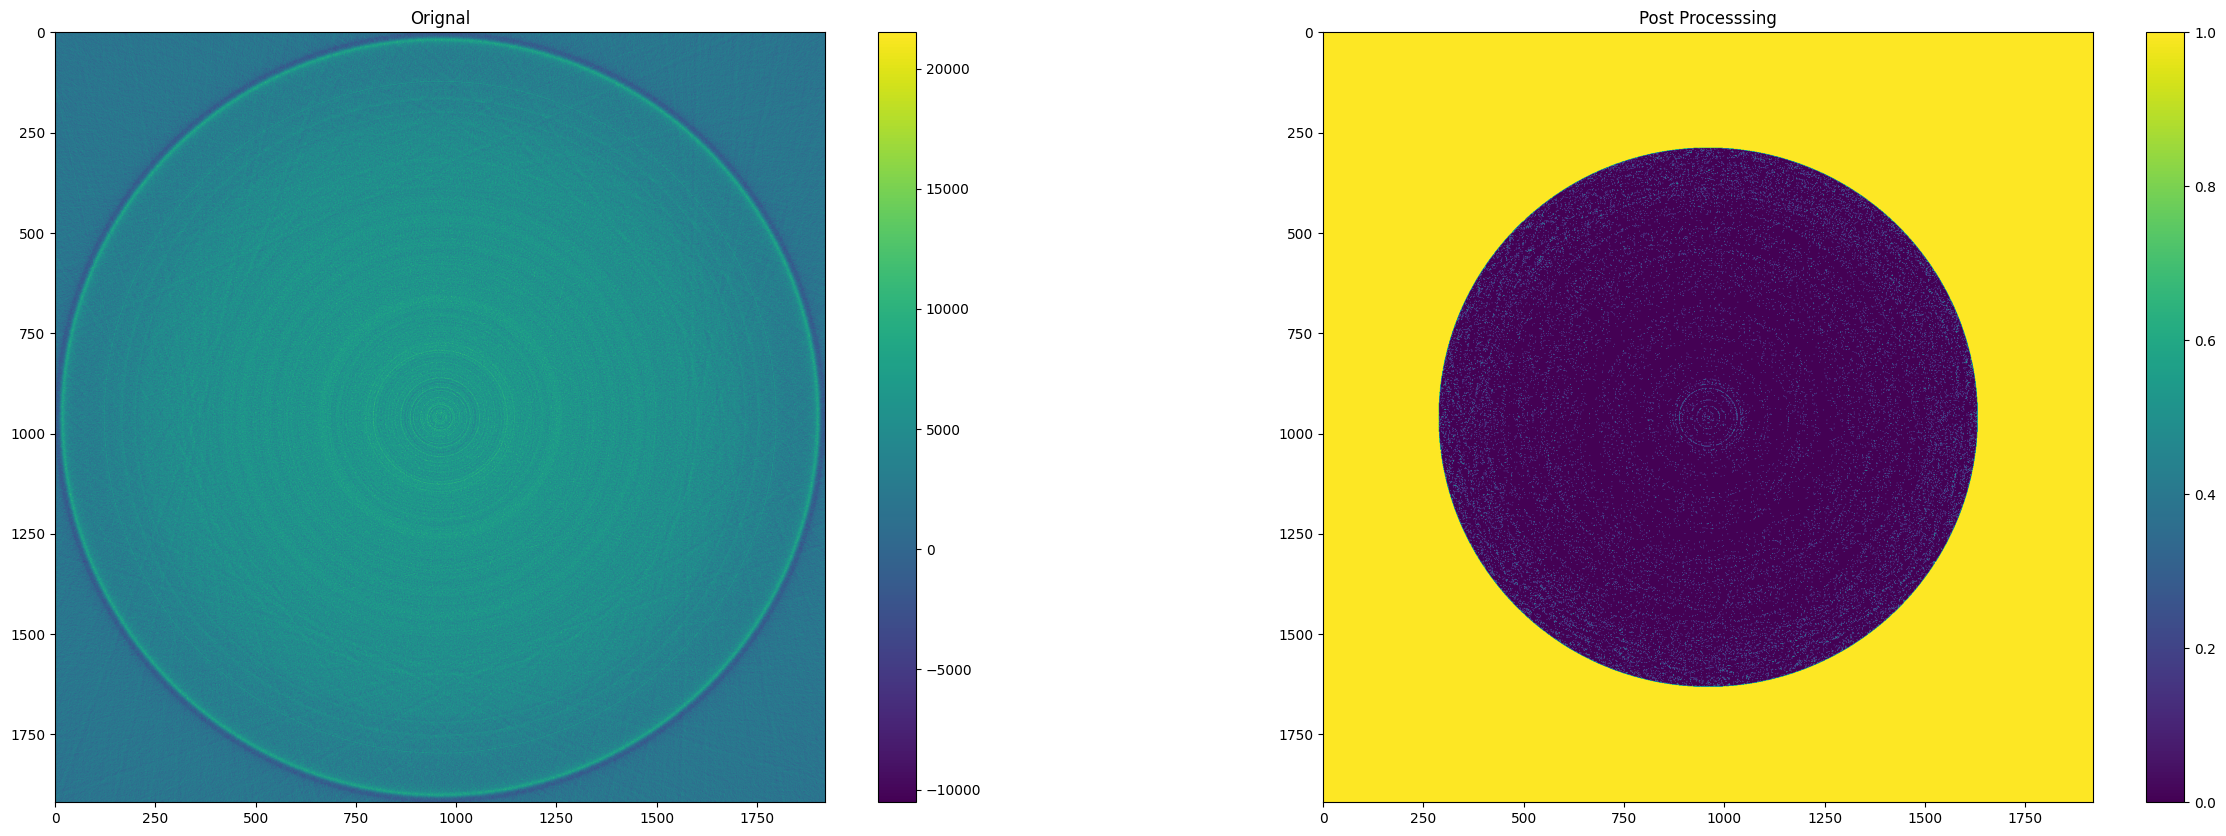

In [32]:
im_layer = 599

w_ = nu.plot_recon_compare(recon_original, recon, im_layer)

In [ ]:
recon_labels, _ = sp.ndimage.label(recon, structure=np.ones((3,3,3), dtype=np.uint8))
voids_b = Voids().count_voids(recon_labels, pixel_ds, dust_thresh=2, pad_bb=2)    

In [ ]:
# Insert polygon pipeline here


In [ ]:
output_path = 'working_dir/pipeline_out/recon.ply'


voids_b.export_void_mesh_mproc("sizes", edge_thresh=0).write_ply(
    os.path.join(output_path))